The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Saved as pollutant_diffusion.eps
Saved as pollutant_diffusion.pdf
Saved as pollutant_diffusion.png


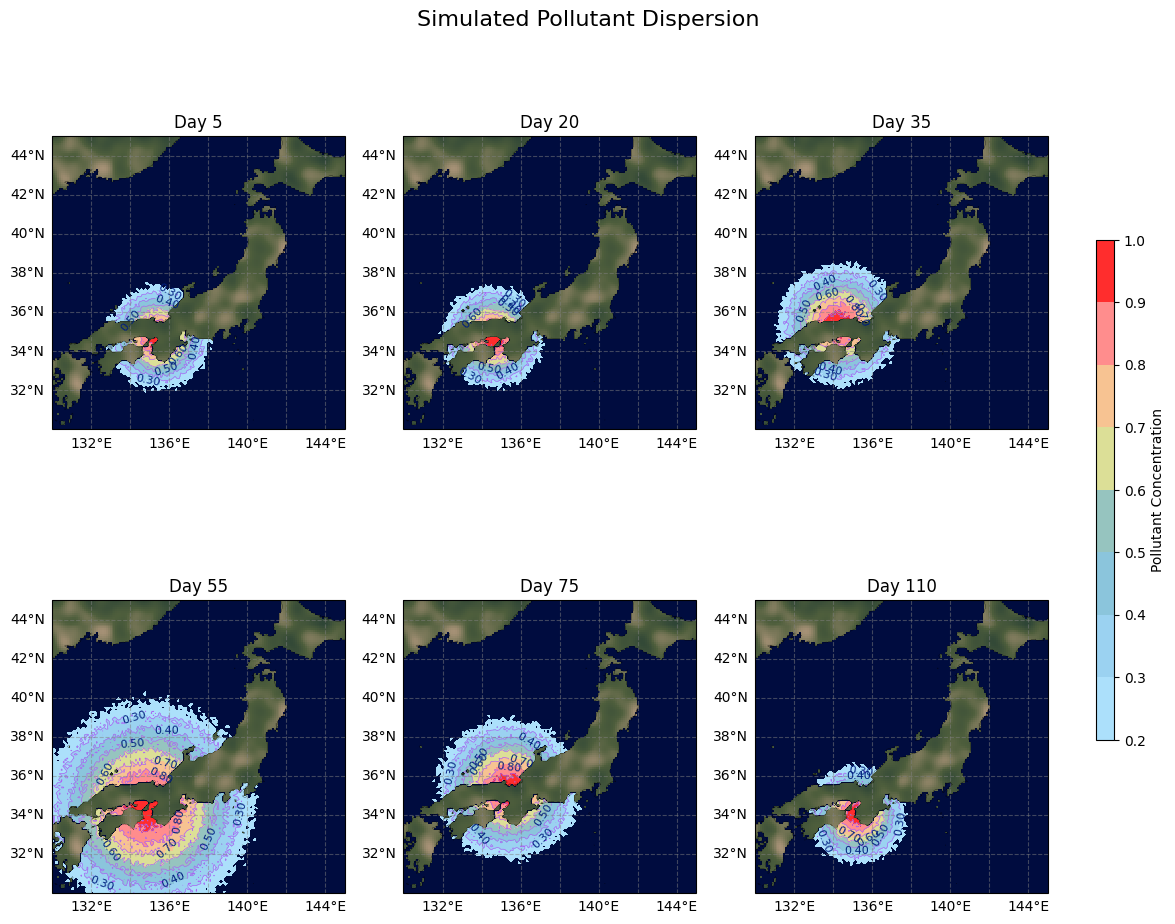

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from shapely.vectorized import contains
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import math

def plot_pollutant_diffusion(lon_grid, lat_grid, pollutant_data, days, pollutant_name):
    land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    land_geoms = list(land_feature.geometries())
    ocean_mask = np.ones(lon_grid.shape, dtype=bool)
    
    for geom in land_geoms:
        ocean_mask &= ~contains(geom, lon_grid, lat_grid)
        
    elev_noise = np.random.rand(*lon_grid.shape)
    land_elev = gaussian_filter(elev_noise, sigma=3) * 1000
    land_elev[ocean_mask] = np.nan
    land_colors = [(0.0, "#2e4536"), (0.5, "#4e5e3c"), (1.0, "#a69176")]
    land_cmap = mcolors.LinearSegmentedColormap.from_list("satellite_land", land_colors)
    pollutant_colors = [(0.0, "#b3e6ff"), (0.2, "#9ad1f0"), (0.4, "#80bccc"), (0.6, "#f0e68c"), (0.8, "#ff9999"), (1.0, "#ff0000")]
    pollutant_cmap = mcolors.LinearSegmentedColormap.from_list("pollutant_custom", pollutant_colors)
    
    contour_levels = np.linspace(0.2, 1.0, 9)
    
    n = len(days)
    ncols = 3
    nrows = math.ceil(n / ncols)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 5 * nrows), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = np.array(axes).flatten()
    fig.suptitle(pollutant_name, fontsize=16)
    
    for i, day in enumerate(days):
        ax = axes[i]
        ax.set_extent([lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], crs=ccrs.PlateCarree())
        ax.set_facecolor('#000c3f')
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        ax.pcolormesh(lon_grid, lat_grid, land_elev, cmap=land_cmap, shading='auto', transform=ccrs.PlateCarree())
        pollutant = np.copy(pollutant_data[i])
        pollutant[pollutant < 0.2] = np.nan
        pollutant[~ocean_mask] = np.nan
        
        cf = ax.contourf(lon_grid, lat_grid, pollutant, levels=contour_levels, cmap=pollutant_cmap, alpha=1, transform=ccrs.PlateCarree())
        cl = ax.contour(lon_grid, lat_grid, pollutant, levels=contour_levels, colors='#aa66f5', linewidths=0.5, transform=ccrs.PlateCarree())
        ax.clabel(cl, inline=True, fmt="%.2f", fontsize=8, colors="#001f7f")
        ax.coastlines(resolution='10m', color='black', linewidth=0.2)
        ax.set_title(f"Day {day}", fontsize=12)
        
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
        
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(cf, cax=cbar_ax)
    cb.set_label('Pollutant Concentration')
    
    fig.subplots_adjust(left=0.05, right=0.88, bottom=0.05, top=0.9)
    dpi_value = 300
    
    fig.savefig("pollutant_diffusion.eps", format="eps", dpi=dpi_value)
    print("Saved as pollutant_diffusion.eps")
    fig.savefig("pollutant_diffusion.pdf", format="pdf", dpi=dpi_value)
    print("Saved as pollutant_diffusion.pdf")
    fig.savefig("pollutant_diffusion.png", format="png", dpi=dpi_value)
    print("Saved as pollutant_diffusion.png")
    plt.show()

if __name__ == "__main__":
    lon_min, lon_max = 130, 145
    lat_min, lat_max = 30, 45
    resolution = 0.1
    
    lons = np.arange(lon_min, lon_max + resolution, resolution)
    lats = np.arange(lat_min, lat_max + resolution, resolution)
    lon_grid, lat_grid = np.meshgrid(lons, lats)
    
    days = [5, 20, 35, 55, 75, 110]
    
    pollutant_data = []
    
    for _ in days:
        center_lon = 135.0 + np.random.uniform(-1, 1)
        center_lat = 35.0 + np.random.uniform(-1, 1)
        scale = np.random.uniform(1.0, 3.0)
        dist_lon = lon_grid - center_lon
        dist_lat = lat_grid - center_lat
        field = np.exp(-((dist_lon**2 + dist_lat**2) / (2 * scale**2)))
        field += 0.1 * np.random.rand(*lon_grid.shape)
        field /= field.max()
        pollutant_data.append(field)
        
    pollutant_name = "Simulated Pollutant Dispersion "
    plot_pollutant_diffusion(lon_grid, lat_grid, pollutant_data, days, pollutant_name)


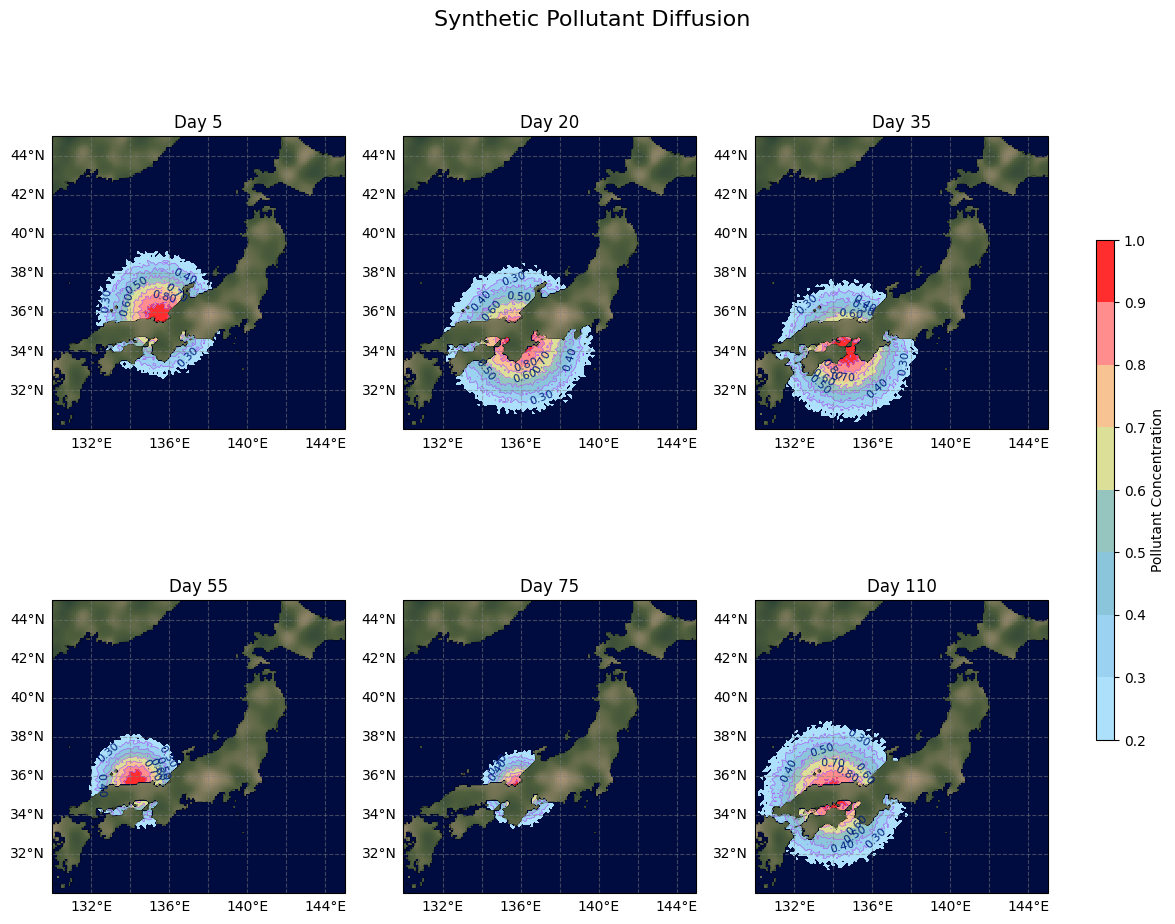

GIF saved as 'pollutant_diffusion.gif'


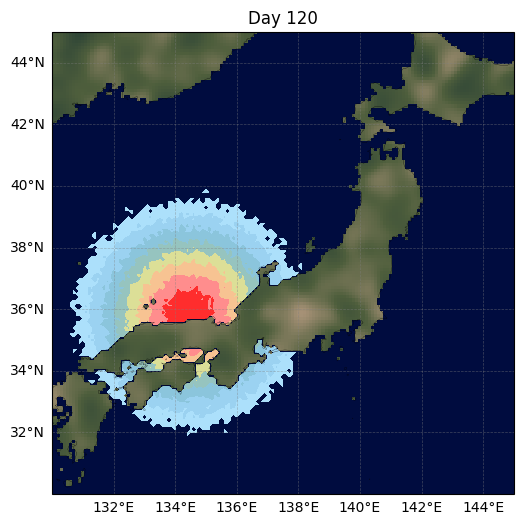

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
from cartopy import feature as cfeature
from shapely.vectorized import contains
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import math

def plot_pollutant_diffusion(lon_grid, lat_grid, pollutant_data, days, pollutant_name, pollutant_data_all_days=None):
    land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m')
    land_geoms = list(land_feature.geometries())
    ocean_mask = np.ones(lon_grid.shape, dtype=bool)
    for geom in land_geoms:
        ocean_mask &= ~contains(geom, lon_grid, lat_grid)

    elev_noise = np.random.rand(*lon_grid.shape)
    land_elev = gaussian_filter(elev_noise, sigma=3) * 1000
    land_elev[ocean_mask] = np.nan
    
    land_colors = [(0.0, "#2e4536"), (0.5, "#4e5e3c"), (1.0, "#a69176")]
    land_cmap = mcolors.LinearSegmentedColormap.from_list("satellite_land", land_colors)
    pollutant_colors = [(0.0, "#b3e6ff"), (0.2, "#9ad1f0"), (0.4, "#80bccc"),
                        (0.6, "#f0e68c"), (0.8, "#ff9999"), (1.0, "#ff0000")]
    pollutant_cmap = mcolors.LinearSegmentedColormap.from_list("pollutant_custom", pollutant_colors)
    contour_levels = np.linspace(0.2, 1.0, 9)

    n = len(days)
    ncols = 3
    nrows = math.ceil(n / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(4 * ncols, 5 * nrows),
                             subplot_kw={'projection': ccrs.PlateCarree()})
    axes = np.array(axes).flatten()
    fig.suptitle(pollutant_name, fontsize=16)

    for i, day in enumerate(days):
        ax = axes[i]
        ax.set_extent([lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()], crs=ccrs.PlateCarree())
        ax.set_facecolor('#000c3f')
        gl = ax.gridlines(draw_labels=True, linewidth=0.8, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        ax.pcolormesh(lon_grid, lat_grid, land_elev, cmap=land_cmap, shading='auto', transform=ccrs.PlateCarree())
        pollutant = np.copy(pollutant_data[i])
        pollutant[pollutant < 0.2] = np.nan
        pollutant[~ocean_mask] = np.nan
        cf = ax.contourf(lon_grid, lat_grid, pollutant, levels=contour_levels,
                         cmap=pollutant_cmap, alpha=1, transform=ccrs.PlateCarree())
        cl = ax.contour(lon_grid, lat_grid, pollutant, levels=contour_levels,
                        colors='#aa66f5', linewidths=0.5, transform=ccrs.PlateCarree())
        ax.clabel(cl, inline=True, fmt="%.2f", fontsize=8, colors="#001f7f")
        ax.coastlines(resolution='10m', color='black', linewidth=0.2)
        ax.set_title(f"Day {day}", fontsize=12)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
    cb = fig.colorbar(cf, cax=cbar_ax)
    cb.set_label('Pollutant Concentration')
    fig.subplots_adjust(left=0.05, right=0.88, bottom=0.05, top=0.9)
    dpi_value = 300
    
    # fig.savefig("pollutant_diffusion.eps", format="eps", dpi=dpi_value)
    # print("Saved as pollutant_diffusion.eps")
    # fig.savefig("pollutant_diffusion.pdf", format="pdf", dpi=dpi_value)
    # print("Saved as pollutant_diffusion.pdf")
    # fig.savefig("pollutant_diffusion.png", format="png", dpi=dpi_value)
    # print("Saved as pollutant_diffusion.png")
    plt.show()

    if pollutant_data_all_days is not None:
        fig_anim, ax_anim = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})
        ax_anim.set_extent([lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()])
        ax_anim.set_facecolor('#000c3f')
        gl = ax_anim.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        ax_anim.pcolormesh(lon_grid, lat_grid, land_elev, cmap=land_cmap,
                           shading='auto', transform=ccrs.PlateCarree())
        ax_anim.coastlines(resolution='10m', color='black', linewidth=0.2)
        title = ax_anim.set_title("")

        img = [ax_anim.contourf(lon_grid, lat_grid, np.full_like(lon_grid, np.nan),
                                levels=contour_levels, cmap=pollutant_cmap, transform=ccrs.PlateCarree())]

        def update(frame):
            img[0].remove()
            data = np.copy(pollutant_data_all_days[frame])
            data[data < 0.2] = np.nan
            data[~ocean_mask] = np.nan
            img[0] = ax_anim.contourf(lon_grid, lat_grid, data,
                                      levels=contour_levels, cmap=pollutant_cmap, transform=ccrs.PlateCarree())
            title.set_text(f"Day {frame + 1}")
            return []

        ani = animation.FuncAnimation(fig_anim, update, frames=len(pollutant_data_all_days), interval=200, blit=False)
        ani.save("./output/pollutant_diffusion.gif", writer='pillow', fps=5)
        print("GIF saved as 'pollutant_diffusion.gif'")

if __name__ == "__main__":
    lon_min, lon_max = 130, 145
    lat_min, lat_max = 30, 45
    resolution = 0.1
    lons = np.arange(lon_min, lon_max + resolution, resolution)
    lats = np.arange(lat_min, lat_max + resolution, resolution)
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    days = [5, 20, 35, 55, 75, 110]
    total_days = 120
    pollutant_data = []
    pollutant_data_all_days = []

    for day in range(1, total_days + 1):
        center_lon = 135.0 + np.sin(day / 10.0)  
        center_lat = 35.0 + np.cos(day / 10.0)
        scale = 1.5 + 0.5 * np.sin(day / 15.0)
        dist_lon = lon_grid - center_lon
        dist_lat = lat_grid - center_lat
        field = np.exp(-((dist_lon ** 2 + dist_lat ** 2) / (2 * scale ** 2)))
        field += 0.1 * np.random.rand(*lon_grid.shape)
        field /= field.max()
        pollutant_data_all_days.append(field)

    for d in days:
        pollutant_data.append(pollutant_data_all_days[d - 1])

    pollutant_name = "Synthetic Pollutant Diffusion"
    plot_pollutant_diffusion(lon_grid, lat_grid, pollutant_data, days, pollutant_name, pollutant_data_all_days)